This notebook will utilize the MNIST dataset to aid in training a neural network (NN) that can recognize digits. Its performance will then be test on some Sudoku puzzles, but it is expected as of now that it may not be perfect since this dataset containts handwritten digits. Sudoku puzzles are typically printed in a nicer fashion. Therefore, it may be wise to explore and expand the training dataset to also incorporate printed Sudoku puzzles. This may make it easier for the NN to then recognize puzzles that have been printed and partially filled in. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
from copy import copy
import re
import os

from python_helper_functions import parse_dat, parseCells, format_inputs_cells, detectSudokuPuzzle
from NumberModel import NumberModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# print the contents of a .dat file that corresponds to an image from the warped dataset
print(parse_dat('./warped_dataset/image1082.dat'))

[[3 4 7 0 5 1 0 0 0]
 [0 1 9 0 0 0 0 0 0]
 [5 0 6 3 4 0 0 0 0]
 [0 7 0 0 0 3 0 0 2]
 [0 0 1 0 0 0 7 0 0]
 [9 0 0 8 0 0 0 5 0]
 [0 0 0 0 3 5 6 0 8]
 [0 0 0 0 0 0 3 2 0]
 [0 0 0 6 8 0 5 9 1]]


The *warped_dataset/* is a folder that contains the warped images of the original Sudoku dataset. This block of code takes the images in this folder and parses them into 81 cells with a corresponding label and saves them to the *cell_dataset/* path. 

In [5]:
warped_path = "./warped_dataset/"
cell_path = "./cell_dataset/"
all_filenames = os.listdir(warped_path)
warped_jpg_filenames = sorted([filename for filename in all_filenames if re.search(r"\.jpg", filename)]) # holds jpg images
warped_dat_filenames = sorted([filename for filename in all_filenames if re.search(r"\.dat", filename)]) # holds label information

folder_counter = np.zeros(10, dtype=np.int32)
for i in range(len(warped_dat_filenames)):
    # get full path and convert image to grayscale
    curr_dat_path = warped_path + warped_dat_filenames[i]
    curr_jpg_path = warped_path + warped_jpg_filenames[i]

    # parse to get the cells and corresponding labels
    cells, labels = parseCells(curr_jpg_path, curr_dat_path)

    # write to the cell_dataset directory and organize every cell image by its label
    for k, label in enumerate(labels):
        label_path = cell_path + str(label) + "/"
        if not os.path.exists(label_path):
            os.makedirs(label_path)

        sub_image = cells[k]
        cv2.imwrite(label_path + str(folder_counter[label]) + ".jpg", sub_image)
        folder_counter[label] += 1

The *models/* directory holds *.pth* files which contains parameters for a **NumberModel** neural network. In this block, we initialize this net and load the weights. 

In [2]:
model_path = "./models/NumberModel_v0.pth"

# load in parameters needed to initialize the model
pth_dict = torch.load(model_path)
state_dict = pth_dict["state_dict"]
lrate = pth_dict["lrate"]
loss_fn = pth_dict["loss_fn"]
image_dim = pth_dict["image_dim"]
out_size = pth_dict["out_size"]

# initialize model with weights
NetObject = NumberModel(lrate, loss_fn, image_dim, out_size).to(device)
NetObject.load_state_dict(state_dict)
NetObject.eval()

NumberModel(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Here we simply test the model on a warped image. The warped image is first parsed into 81 cells, and then the number in each cell is inferred by the model. Finally, the inferences are ensembled in the same format as a .dat file and compared. 

In [5]:
test_name = "image1"
warped_img_path = f"./warped_dataset/{test_name}.jpg"
dat_path = f"./warped_dataset/{test_name}.dat"

# display the correct output
correct_output = parse_dat(dat_path)
print(f"Correct output:")
print(correct_output)

# parse a warped image into cells and predict the number in each cell
cells, _ = parseCells(warped_img_path, dat_path)
cell_tensor = format_inputs_cells(cells).to(device)
outputs = NetObject(cell_tensor)
_, predicted = torch.max(outputs, 1)
predicted = predicted.detach().cpu().numpy()
predicted = predicted.reshape(9, 9)
print(f"Inferred output:")
print(predicted)

# print differences
print(f"Element-wise difference in correct output and predicted output:")
print((correct_output == predicted))

Correct output:
[[0 0 0 7 0 0 0 8 0]
 [0 9 0 0 0 3 1 0 0]
 [0 0 6 8 0 5 0 7 0]
 [0 2 0 6 0 0 0 4 9]
 [0 0 0 2 0 0 0 5 0]
 [0 0 8 0 4 0 0 0 7]
 [0 0 0 9 0 0 0 3 0]
 [3 7 0 0 0 0 0 0 6]
 [1 0 5 0 0 4 0 0 0]]
Inferred output:
[[0 0 0 7 0 0 0 8 0]
 [0 9 0 0 0 3 1 0 0]
 [0 0 6 8 0 5 0 7 0]
 [0 2 0 6 0 0 0 4 9]
 [0 0 0 2 0 0 0 5 0]
 [0 0 8 0 4 0 0 0 7]
 [0 0 0 9 0 0 0 3 0]
 [3 7 0 0 0 0 0 0 6]
 [1 0 5 0 0 4 0 0 0]]
Element-wise difference in correct output and predicted output:
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]


Here, we demonstrate the full computer vision implementation where an image from the original dataset is first warped and then the predicted number outputs are displayed.

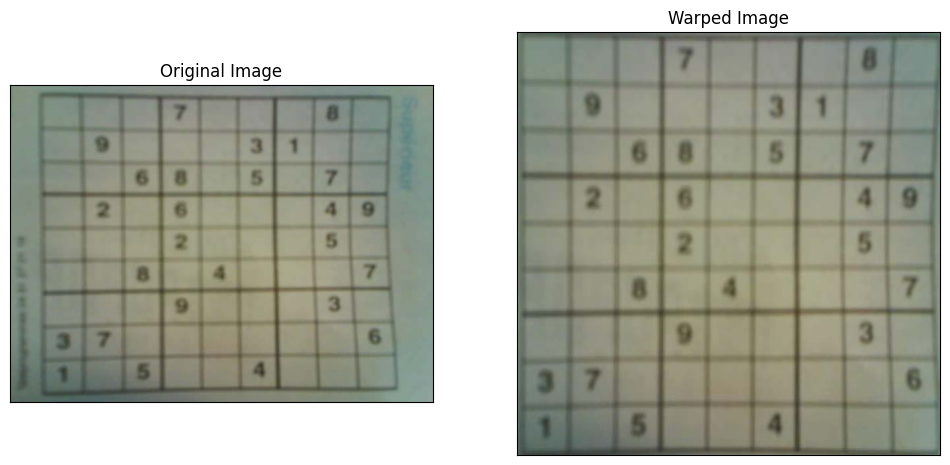

Correct output:
[[0 0 0 7 0 0 0 8 0]
 [0 9 0 0 0 3 1 0 0]
 [0 0 6 8 0 5 0 7 0]
 [0 2 0 6 0 0 0 4 9]
 [0 0 0 2 0 0 0 5 0]
 [0 0 8 0 4 0 0 0 7]
 [0 0 0 9 0 0 0 3 0]
 [3 7 0 0 0 0 0 0 6]
 [1 0 5 0 0 4 0 0 0]]
[array([[[125, 140, 121],
        [120, 135, 116],
        [113, 128, 109],
        ...,
        [ 86, 109,  93],
        [ 86, 109,  93],
        [ 86, 109,  93]],

       [[124, 138, 121],
        [116, 132, 114],
        [109, 124, 106],
        ...,
        [ 83, 102,  88],
        [ 83, 102,  89],
        [ 83, 102,  89]],

       [[121, 138, 122],
        [112, 131, 113],
        [104, 122, 104],
        ...,
        [ 83,  96,  86],
        [ 85,  98,  88],
        [ 86,  98,  88]],

       ...,

       [[118, 136, 120],
        [110, 128, 112],
        [105, 123, 107],
        ...,
        [129, 141, 127],
        [131, 143, 129],
        [129, 141, 127]],

       [[118, 136, 120],
        [110, 128, 112],
        [105, 123, 107],
        ...,
        [127, 139, 125],
       

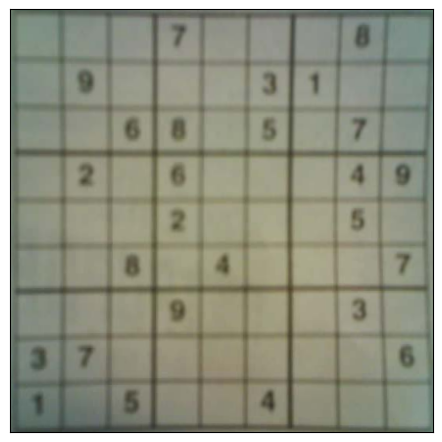

In [8]:
test_name = "image1"
original_img_path = f"./original_dataset/{test_name}.jpg"
dat_path = f"./original_dataset/{test_name}.dat"

original_img = cv2.cvtColor(cv2.imread(original_img_path), cv2.COLOR_BGR2RGB)
warped_img = detectSudokuPuzzle(original_img_path)

fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(original_img, 'gray')
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,1)
plt.imshow(warped_img, 'gray')
plt.xticks([]),plt.yticks([])
    
# display the correct output
correct_output = parse_dat(dat_path)
print(f"Correct output:")
print(correct_output)

# parse a warped image into cells and predict the number in each cell
cells, _ = parseCells(warped_img, dat_path)
print(cells)

In [ ]:
cell_tensor = format_inputs_cells(cells).to(device)
outputs = NetObject(cell_tensor)
_, predicted = torch.max(outputs, 1)
predicted = predicted.detach().cpu().numpy()
predicted = predicted.reshape(9, 9)
print(f"Inferred output:")
print(predicted)

# print differences
print(f"Element-wise difference in correct output and predicted output:")
print((correct_output == predicted))